In [1]:
def gini_criterion(x: list, y: list, print_=False)-> int: 
    import numpy as np
    """Вычисление критерия Джини"""
    n_classes  = len(set(y)) # всего уникальных класов
    n_examples = len(x) # всего примеров
    
    def border_list(x: list) -> list:
        """Принимаем список значений, возвращаем индексы элементов, 
        после которых нужно попробовать провести границу"""
        border_list = []

        for idx, ex in enumerate(x):
            if idx != (n_examples - 1): # если индекс не последний
                try:
                    if y[idx+1] != y[idx]: # если следуюший элемент отличается
                        border_list.append(idx) # сохраняем в список
                    else:
                        pass
                except:
                    pass
            else:
                pass
        return border_list
    # список с массивами частот встречаемости классов (отсортированных по порядку)
    H_general_cls_freq = [np.where(np.array(y) == cls)[0].shape[0] \
                          for cls in sorted(list(set(y)))]
    # значение H(R) для всего списка
    H_general = sum([f/len(x)*(1-f/len(x)) for f in H_general_cls_freq])
    
    borders = border_list(x)
    
    res_dict = {}
    
    for b in borders:
        # разбиваем списки по индексу из списка границ
        x_left, y_left = x[:b+1], y[:b+1]
        x_right, y_right = x[b+1:], y[b+1:]
        #  значение H(Rleft) для левой части списка
        H_left_cls_freq = [np.where(np.array(y_left) == cls)[0].shape[0] \
                           for cls in sorted(list(set(y_left)))]
        H_left = sum([f/len(x_left)*(1-f/len(x_left)) for f in H_left_cls_freq])
        #  значение H(Rright) для правой части списка
        H_right_cls_freq = [np.where(np.array(y_right) == cls)[0].shape[0] \
                            for cls in sorted(list(set(y_right)))]
        H_right = sum([f/len(x_right)*(1-f/len(x_right)) for f in H_right_cls_freq])
        #  значение information gain по формуле
        IG = round(H_general - H_left*len(x_left)/len(x) - H_right*len(x_right)/len(x), 3)
        
        res_dict[b]=IG
                
#         print(IG)
    # индекс границы, для которой IG максимально
    res = max(res_dict, key=res_dict.get)
    if print_:
        print(f"Проводим границу после элемента с индексом {res}")
    
    return 
            
gini_criterion([1,2,3,4,5,6,7,8,9], [0,1,0,0,1,1,0,1,1], print_= True)

Проводим границу после элемента с индексом 3


##### Логистическая функция

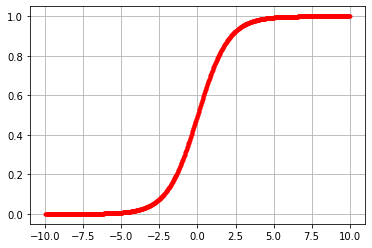

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def sigm(t):
    return 1/(1+np.e**(-t))
xx = np.linspace(-10,10, 1000)
yy = sigm(xx)

plt.plot(xx,yy, "r.", linewidth=2, label="train")
plt.grid()
plt.show()

/home/admin1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


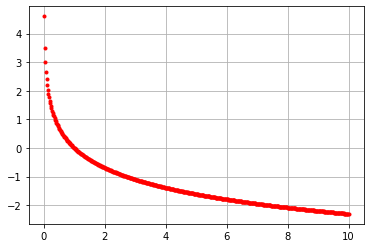

In [3]:
def neg_log(x, y):
    return -1*np.log(x)
xx = np.linspace(-10,10, 1000)
yy = neg_log(xx, 10)

plt.plot(xx,yy, "r.", linewidth=2, label="train")
plt.grid()
plt.show()

In [4]:
-np.log(0.0001)

9.210340371976182

#### AdaBoost

см. стр. 254-255 книги Орельена Жерона + неплохая статья https://www.machinelearningmastery.ru/machine-learning-part-17-boosting-algorithms-adaboost-in-python-d00faac6c464/

In [7]:
def get_r(w: np.ndarray, w_false: np.ndarray) -> float:
    """Функция возвращает взвешенную частоту ошибок - 
    отношение суммы весов обучающих примеров,
    классифицированных неправильно,
    к всей сумме весов."""
    return np.sum(w_false)/np.sum(w)

# def get_r(w: np.ndarray, w_false: np.ndarray) -> float:
#     """Функция возвращает сумму весов обучающих примеров,
#     классифицированных неправильно,
#     """
#     return np.sum(w_false)

def get_alpha(r: float, eta=0.01):
    """Функция возвращает 
    вес прогнозатора (параметр альфа)
    epsilon: малое число, позволяющее избегать деления на 0,
    когда ошибка r нулевая (обычно при использовании сложных моделей,
    способных с первых попыток дать accuracy 100%)
    """
    if r != 0:
        return eta * np.log((1 - r)/(r))
    else:
        epsilon = 10**(-6)
        return eta * np.log((1 - r)/(r+epsilon))

def custom_adaboost_binary(clf, 
                           X_train: np.ndarray, 
                           X_test: np.ndarray, 
                           y_train: np.ndarray, 
                           y_test: np.ndarray, 
                           n_iter=200, 
                           eta=0.5,
                           sample_size=0.5,
                           random_init=False,
                           prnt=True) -> np.ndarray:
    """Реализует алгоритм AdaBoost 
    для бинарной классификации.
    clf:     экземпляр классификатора из sklearn 
    (например: sklearn.tree._classes.DecisionTreeClassifier),
    X_train: массив numpy array с тренировочным сетом, 
    X_test:  массив numpy array с тренировочным сетом, 
    y_train: массив numpy array с тренировочным сетом, 
    y_test:  массив numpy array с тренировочным сетом, 
    n_iter:  количество итераций fit/predict для классификатора, 
    eta:     скорость обучения для alpha (веса классификаторов),
    random_init: случайная инициализация весов (да/нет),
    prnt:    выводить или нет на печать промежуточные результаты.
    """
    # веса для каждого обучающего примера (массив формы (-1,1))
    # веса нормализованы так, что в сумме дают 1
    # случайная инициализация весов
    if random_init:
        weights = np.abs(np.random.normal(1000, 300, X_train.shape[0])).reshape(-1,1)
        weights /= np.sum(weights)
    # инициализация одинаковых весов для всех образцов train
    else:
        weights = np.ones((X_train.shape[0], 1))# / X_train.shape[0]
    # будущий массив с предсказаниями (формы (n_iter, X_test.shape[0]))
    predictions_for_train = None 
    predictions_for_test  = None
    # будущий массив с весами классификаторов (формы (n_iter, 1))
    alphas = None
    # будущий массив с расчетными показателями precision для test set
    precisions = None
    # пустой список для сохранения обученных классификаторов
    clfs = []
    # инициируем размер семпла 
    sample_sizes = np.linspace(1,100, n_iter)/100
        
    # для каждой итерации обучаем классификатор на случайной подвыборке из train
    for i in range(n_iter):
        # копируем инстанс классификатора
#         clf_i = clone(clf)
        clf_i = copy.deepcopy(clf)
        # если это нулевая итерация
        if predictions_for_train is None:
            # делаем выборку из train размера sample_size % массива train 
            # с учетом весов weights (вероятностей попасть в выборку)  
            idx_sel = [
                random.choices(list(range(X_train.shape[0])), weights)[0] 
                for i in range(np.int(X_train.shape[0]*sample_sizes[i]))
            ]
            # обучаем классификатор
            clf_i.fit(X_train[idx_sel,:], y_train[idx_sel])
            # делаем prediction (массив формы (1, X_test.shape[0]//2))
            # для train и для test отдельно
            pred_for_train = clf_i.predict(X_train).astype('int').reshape(1,-1)
            pred_for_test  = clf_i.predict(X_test).astype('int').reshape(1,-1)
            # создаем массивы для записи предсказаний классификатора
            predictions_for_train = pred_for_train
            predictions_for_test = pred_for_test
            
        else:
            idx_sel = [
                random.choices(list(range(X_train.shape[0])), weights)[0] 
                for i in range(np.int(X_train.shape[0]*sample_sizes[i]))]
            clf_i.fit(X_train[idx_sel,:], y_train[idx_sel])
            pred_for_train = clf_i.predict(X_train).astype('int').reshape(1,-1)
            pred_for_test  = clf_i.predict(X_test).astype('int').reshape(1,-1)
            # присоединяем вектор-строку снизу к массиву предсказаний
            predictions_for_train = np.vstack([predictions_for_train, pred_for_train])   
            predictions_for_test = np.vstack([predictions_for_test, pred_for_test])      
        # сохраним обученный классификатор
        clfs.append(clf_i)
        # индексы образцов в train, по которым классификатор ошибся
        idx_err = np.where(pred_for_train.reshape(-1) != y_train.reshape(-1))[0]
        # сразу получим массив с индексами правильно классифицированных образцов
        idx_cor = np.array(
            list(
                set(list(range(X_train.shape[0]))) - set(idx_err)
            )
        ).reshape(-1)
        # вычисляем взвешенную частоту ошибок классификатора
        r = get_r(weights, weights[idx_err, :])
        
        # если это нулевая итерация
        if alphas is None:
            # получаем вес классификатора
            alpha = get_alpha(r, eta=eta).reshape(1,1)
            alphas = alpha
        else:
            alpha = get_alpha(r, eta=eta).reshape(1,1)
            # присоединяем массив формы (1,1) снизу к массиву весов классификаторов
            alphas = np.vstack([alphas, alpha])
        
        # обновим веса обучающих образцов
        weights[idx_err,:] = weights[idx_err,:] * np.exp(alpha) # увеличим для ошибок
        weights[idx_cor,:] = weights[idx_cor,:] * np.exp(-alpha) # уменьшим для верных
        # и нормируем, чтобы сумма весов была равна 1
        weights /= np.sum(weights)
        # если это нулевая итерация
        if precisions is None:
            # получаем вес классификатора
            prec = accuracy_score(y_test.reshape(-1), pred_for_test.reshape(-1)).reshape(1,1)
            precisions = prec
        else:
            prec = accuracy_score(y_test.reshape(-1), pred_for_test.reshape(-1)).reshape(1,1)
            # присоединяем массив формы (1,1) снизу к массиву весов классификаторов
            precisions = np.vstack([precisions, prec])
            
        if prnt and i%10 == 0:
            print(f"iter {i}")
            print(f"r:{r}")
            print(f"alpha:{alpha[0][0]}")
            print(clf_i.__class__.__name__, "accuracy (test):",
                  accuracy_score(y_test.reshape(-1), pred_for_test.reshape(-1)))
            print(f"examples:{np.int(X_train.shape[0]*sample_sizes[i])}")
            print('-'*10)
    
    # находим индекс самого большого значения alpha и по возможности preision
    final_arr = np.hstack([np.arange(n_iter).reshape(-1,1), 
                           alphas.reshape(-1,1), 
                           precisions.reshape(-1,1)])
    # превращаем данные в список кортежей
    data_raw = [(final_arr[i,0], final_arr[i,1], final_arr[i,2]) for i in range(final_arr.shape[0])]
    # определяем "типы" для столбцов
    data_type = [('idx', 'float'), ('alpha', 'float'), ('precision', 'float')]
    # собираем все в структурированный массив
    data = np.array(data_raw, dtype = data_type)
    # сортируем по 'alpha', затем по 'precision'
    data_sorted = np.sort(data, order = ['alpha', 'precision'])
    # находим индекс лучшего значения 
    result_idx = int(data_sorted[-1][0])
    
    if prnt:
        print("*"*10)
        print(f"result_idx: {result_idx} precision {precisions[result_idx,:][0]}" 
              + f" alpha {alphas[result_idx,:][0]}")
        
    result = predictions_for_test[result_idx,:] 
    best_clf = clfs[result_idx]
    
    return best_clf, result, weights

In [8]:
# from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.base import clone
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_moons, make_blobs
from sklearn.model_selection import train_test_split
import random
import copy

dtc = DecisionTreeClassifier(max_depth=1)
# dtc = DecisionTreeClassifier(max_depth=4)

RS = 44
X, y = make_moons(n_samples=1000, noise=0.15, random_state=RS)
# X, y = make_blobs(n_samples=1000, centers=2, cluster_std=1.1, n_features=2, random_state=RS)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=RS)

Посмотрим на данные (test)

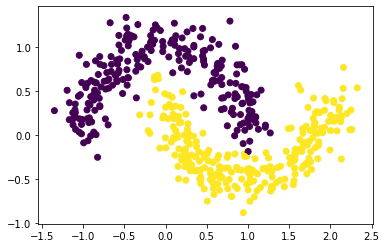

In [9]:
import matplotlib.pyplot as plt
plt.scatter(X_test[:,0], X_test[:,1], c=y_test);

In [16]:
%%time
best_clf, res, weights = custom_adaboost_binary(X_train=X_train, 
                       X_test=X_test, 
                       y_train=y_train, 
                       y_test=y_test, 
                       n_iter=101, 
                       clf=dtc, 
                       eta=0.01, 
                       random_init=False,
                       prnt=True)

iter 0
r:0.256
alpha:0.010668635903535293
DecisionTreeClassifier accuracy (test): 0.736
examples:5
----------
iter 10
r:0.17576391913044284
alpha:0.0154531526876316
DecisionTreeClassifier accuracy (test): 0.83
examples:54
----------
iter 20
r:0.19913453050507024
alpha:0.013917123507666683
DecisionTreeClassifier accuracy (test): 0.834
examples:104
----------
iter 30
r:0.22704060335873802
alpha:0.012250976493157663
DecisionTreeClassifier accuracy (test): 0.822
examples:153
----------
iter 40
r:0.2518344872732221
alpha:0.010888521520047075
DecisionTreeClassifier accuracy (test): 0.796
examples:203
----------
iter 50
r:0.27994154800620813
alpha:0.009447515677838605
DecisionTreeClassifier accuracy (test): 0.756
examples:252
----------
iter 60
r:0.2728718362293675
alpha:0.009801005326991167
DecisionTreeClassifier accuracy (test): 0.794
examples:302
----------
iter 70
r:0.30216024154871934
alpha:0.008370320261766704
DecisionTreeClassifier accuracy (test): 0.734
examples:351
----------
iter 80

In [17]:
# топ-10 значения весов из набора train
weights[weights.reshape(-1).argsort()[::-1][:10]]

array([[0.00790384],
       [0.00781829],
       [0.00724626],
       [0.00672522],
       [0.00599666],
       [0.00577903],
       [0.00572195],
       [0.00529351],
       [0.00529351],
       [0.00529351]])

In [18]:
# непосредственно эти 10 образцов из набора train
X_train[weights.reshape(-1).argsort()[::-1][:10]]

array([[-0.41130294,  0.67712934],
       [ 1.18087979, -0.22328002],
       [ 0.88151893, -0.14981837],
       [ 0.21363411,  0.59742476],
       [ 1.06550892, -0.06785856],
       [ 1.36637124,  0.04871828],
       [ 2.02746216,  0.65842581],
       [ 0.92861795, -0.0516842 ],
       [ 1.09870758, -0.0438628 ],
       [ 0.95552957, -0.02625743]])

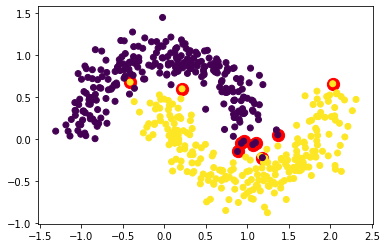

In [19]:
# топ-10 образцов по сложности классификации 
plt.scatter(X_train[weights.reshape(-1).argsort()[::-1][:10]][:,0], X_train[weights.reshape(-1).argsort()[::-1][:10]][:,1], c='r', s=150)
plt.scatter(X_train[:,0], X_train[:,1], c=y_train);

In [20]:
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.7, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    plt.contourf(x1, x2, y_pred, alpha=0.3)
    if contour:
        plt.contour(x1, x2, y_pred, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

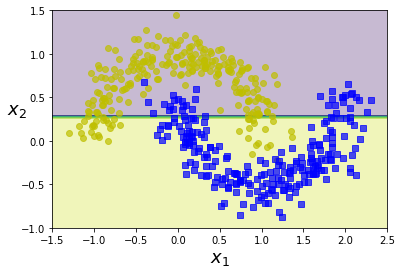

In [21]:
# граница принятия решений
plot_decision_boundary(best_clf, X_train, y_train) # для moons
# plot_decision_boundary(best_clf, X_train, y_train, axes=[0, 11.0, -12., 2.]) # для blobs